## YOY Growth Data

In [59]:
%%capture
#!rm *.jsonl
#!wget -q https://nvd.handsonhacking.org/nvd.jsonl

In [60]:
# Import necessary libraries
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from datetime import date
import calplot
import glob
import json
import logging
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date, timedelta
import warnings

# Register a cell magic for Markdown
@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

# Configure logging and warnings
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

# Set pandas display options
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [61]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)

nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
Year_2025 = ((nvd['Published'] > '2025-01-01') & (nvd['Published']  < '2025-06-01'))
Year_2024 = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2024-06-01'))


nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);

nvd_2025 = nvd.loc[Year_2025]
nvd_2025 = nvd_2025.sort_values(by=['Published'])
nvd_2025 = nvd_2025.reset_index(drop=True)
nvdcount_2025 = nvd_2025['Published'].count()

nvd_2024 = nvd.loc[Year_2024]
nvd_2024 = nvd_2024.sort_values(by=['Published'])
nvd_2024 = nvd_2024.reset_index(drop=True)
nvdcount_2024 = nvd_2024['Published'].count()


In [62]:
Day_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("D")).agg('count')
Day_2025 = nvd_2025['Published'].groupby(nvd_2025.Published.dt.to_period("D")).agg('count')

Day_2024 = Day_2024.reset_index(name="2024")
Day_2024 = Day_2024.rename(columns={"Published": "Day"}, errors="raise")
Day_2024['Day'] = Day_2024['Day'].dt.strftime('%B-%d')

Day_2025 = Day_2025.reset_index(name="2025")
Day_2025 = Day_2025.rename(columns={"Published": "Day"}, errors="raise")
Day_2025['Day'] = Day_2025['Day'].dt.strftime('%B-%d')

Days = pd.merge(Day_2024, Day_2025, how='left')

# Replace NaN values with 0 and round 2025 values to the nearest integer
Days = Days.fillna(0)
Days['2025'] = Days['2025'].round().astype(int)

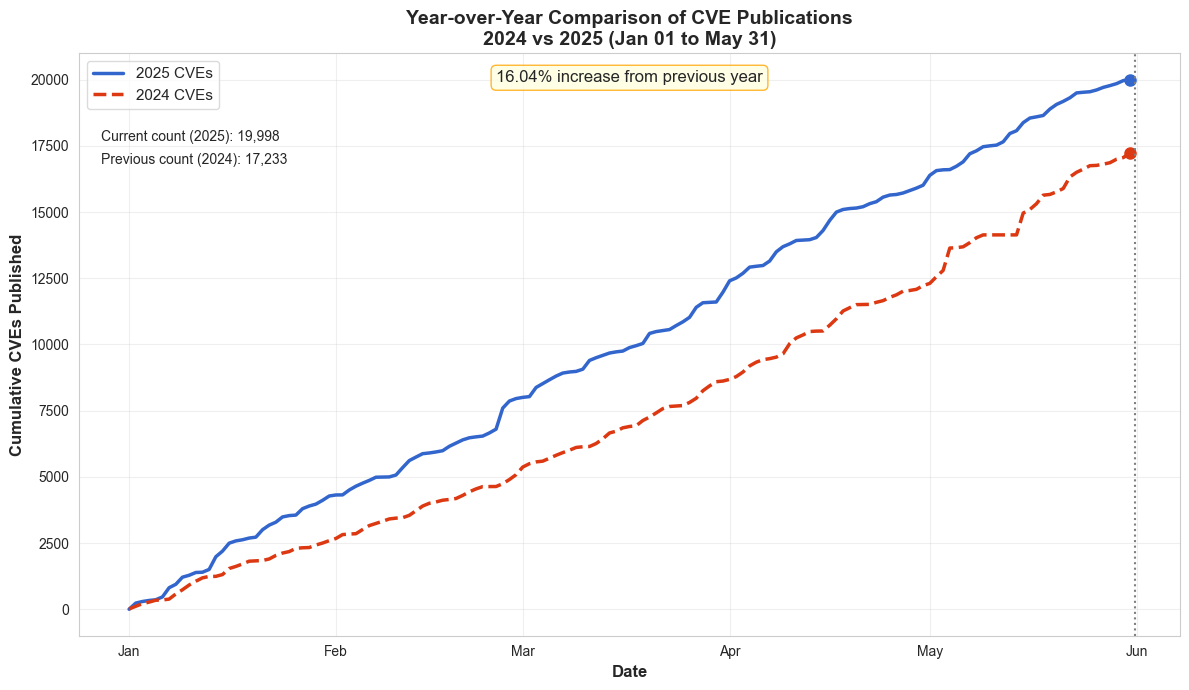

In [68]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.family'] = 'sans-serif'

# Use the boolean masks already defined
current_year_data = nvd[Year_2025]
previous_year_data = nvd[Year_2024]

# Create a function to get cumulative counts by day of year
def get_cumulative_by_doy(data, year):
    daily_counts = data.groupby(data['Published'].dt.dayofyear).size()
    all_days = pd.Series(range(1, 367))
    daily_counts = daily_counts.reindex(all_days, fill_value=0)
    cumulative = daily_counts.cumsum()
    dates = pd.date_range(start=f'{year}-01-01', periods=366)
    return dates, cumulative

current_dates, current_cumulative = get_cumulative_by_doy(current_year_data, current_year)
previous_dates, previous_cumulative = get_cumulative_by_doy(previous_year_data, previous_year)

# Normalize previous year dates to current year for proper alignment
normalized_previous_dates = []
for d in previous_dates:
    try:
        normalized_previous_dates.append(d.replace(year=current_year))
    except ValueError:
        if d.month == 2 and d.day == 29:
            continue

if len(normalized_previous_dates) < len(previous_cumulative):
    normalized_previous_dates.append(pd.Timestamp(f'{current_year}-12-31'))

# Find the last day of year with data for 2025
if not current_year_data.empty:
    last_doy = current_year_data['Published'].dt.dayofyear.max()
    current_cumulative = current_cumulative.iloc[:last_doy]
    current_dates = current_dates[:last_doy]
    previous_cumulative = previous_cumulative.iloc[:last_doy]
    normalized_previous_dates = normalized_previous_dates[:last_doy]

# Use the last available day in current_year_data for slicing
# Instead of slicing, use the full cumulative series up to the last available date
# This ensures the count matches the data output
current_cumulative = current_cumulative  # No slicing
current_dates = current_dates  # No slicing
previous_cumulative = previous_cumulative.iloc[:len(current_cumulative)]
normalized_previous_dates = normalized_previous_dates[:len(current_cumulative)]

fig, ax = plt.subplots()
ax.plot(current_dates, current_cumulative, linewidth=2.5, color='#3366CC', 
        label=f'{current_year} CVEs')
ax.plot(normalized_previous_dates, previous_cumulative, linewidth=2.5, color='#DC3912', 
        linestyle='--', label=f'{previous_year} CVEs')
ax.plot(current_dates[-1], current_cumulative.iloc[-1], 'o', color='#3366CC', markersize=8)
ax.plot(normalized_previous_dates[-1], previous_cumulative.iloc[-1], 'o', color='#DC3912', markersize=8)

if previous_cumulative.iloc[-1] > 0:
    # Use the same calculation as the summary cell for consistency
    percent_change = ((current_cumulative.iloc[-1] - previous_cumulative.iloc[-1]) / previous_cumulative.iloc[-1]) * 100
    change_text = f"{percent_change:.2f}% {'increase' if percent_change > 0 else 'decrease'} from previous year"
    ax.annotate(change_text, 
                xy=(0.5, 0.95), 
                xycoords='axes fraction', 
                ha='center',
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="orange", alpha=0.8))

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Draw a vertical line at the last date in current_year_data
if not current_year_data.empty:
    last_date = current_year_data['Published'].max()
    ax.axvline(last_date, linestyle=':', color='gray')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative CVEs Published', fontsize=12, fontweight='bold')

# Get the min and max date for the current year data for the title
if not current_year_data.empty:
    min_date = current_year_data['Published'].min().strftime('%b %d')
    # Add one day to the max date for the range
    max_date_plus_one = (current_year_data['Published'].max() + pd.Timedelta(days=0)).strftime('%b %d')
    date_range_str = f"({min_date} to {max_date_plus_one})"
else:
    date_range_str = ""

ax.set_title(f'Year-over-Year Comparison of CVE Publications\n{previous_year} vs {current_year} {date_range_str}', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
legend = ax.legend(loc='upper left', frameon=True, fontsize=11)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(0.8)
frame.set_edgecolor('lightgray')
# Use the last value of the cumulative series for the count, as this reflects the true cumulative CVEs published (including days with zero CVEs)
current_count = int(current_cumulative.iloc[-1]) if len(current_cumulative) > 0 else 0
previous_count = int(previous_cumulative.iloc[-1]) if len(previous_cumulative) > 0 else 0
ax.annotate(f'Current count ({current_year}): {current_count:,}', 
            xy=(0.02, 0.85), xycoords='axes fraction', fontsize=10)
ax.annotate(f'Previous count ({previous_year}): {int(previous_count):,}', 
            xy=(0.02, 0.81), xycoords='axes fraction', fontsize=10)
plt.tight_layout()
output_filename = f'YOY_CVE_Comparison_{current_year}_vs_{previous_year}.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
logging.info(f"Plot saved as {output_filename}")
plt.show()

In [67]:
# Function to convert a day to its ordinal representation
def ordinal(n):
    return f"{n}{'th' if 11 <= (n % 100) <= 13 else {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')}"


# Calculate total number of CVEs in 2025
total_cves_2025 = nvd_2025.shape[0]

# Calculate total number of CVEs in 2024
total_cves_2024 = nvd_2024.shape[0]

# Use the same count as the graph (last value of current_cumulative)
graph_total_cves_2025 = int(current_cumulative.iloc[-1]) if len(current_cumulative) > 0 else 0
# Use the same for 2024
graph_total_cves_2024 = int(previous_cumulative.iloc[-1]) if len(previous_cumulative) > 0 else 0

# Calculate average CVEs per day in 2025 (use the number of days in the graph)
graph_days_2025 = len(current_cumulative)
graph_average_cves_per_day_2025 = graph_total_cves_2025 / graph_days_2025 if graph_days_2025 > 0 else 0

# Calculate YOY growth using graph counts
graph_yoy_growth = ((graph_total_cves_2025 - graph_total_cves_2024) / graph_total_cves_2024) * 100 if graph_total_cves_2024 > 0 else 0
graph_yoy_growth_count = graph_total_cves_2025 - graph_total_cves_2024

# Use the last date in the graph for the output date
if len(current_dates) > 0:
    graph_end_date = current_dates[-1].date()
else:
    graph_end_date = end_date_2025

output = f"""
2025 CVE Stats Update ({graph_end_date.strftime('%B')} {ordinal(graph_end_date.day)}, {graph_end_date.year})
Total Number of CVEs: {graph_total_cves_2025}
Average CVEs Per Day: {graph_average_cves_per_day_2025:.2f}
Average CVSS Score: {average_cvss_score_2025:.2f}
YOY Growth: {graph_yoy_growth:.2f}% or +{graph_yoy_growth_count} ({graph_total_cves_2024} CVEs in 2024)
"""

print(output)


2025 CVE Stats Update (May 31st, 2025)
Total Number of CVEs: 19998
Average CVEs Per Day: 132.44
Average CVSS Score: 6.59
YOY Growth: 16.04% or +2765 (17233 CVEs in 2024)

